## Problem STatement

Given a comment made by the user, predict the toxicity of the comment.

## Data

Data is taken from old kaggle competition "[Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/description)".

In the data supplied for this competition, the text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data.

This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment. 

For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).

Columns in train data:
* Comment_text: This is the data in string format which we have to use to find the toxicity.
* target: Target values which are to be predicted (has values between 0 and 1).<br>
Data also has additional toxicity subtype attributes: (Model does not have to predict these)
    * severe_toxicity
    * obscene
    * threat
    * insult
    * identity_attack
    * sexual_explicit
* Comment_text data also has identity attributes carved out from it, some of which are:
    * male
    * female
    * homosexual_gay_or_lesbian
    * christian
    * jewish
    * muslim
    * black
    * white
    * asian
    * latino
    * psychiatric_or_mental_illness
* Apart from above features the train data also provides meta-data from jigsaw like:
    * toxicity_annotator_count
    * identity_anotator_count
    * article_id
    * funny
    * sad
    * wow
    * likes
    * disagree
    * publication_id
    * parent_id
    * article_id
    * created_date

**Type Of ML Prob:**   We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem.<br> It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.

## Performance Metric

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. <br>Any comment above 0.5 will be assumed to be toxic and below it non-toxic. <br>For our training and evaluation we will use the MSE(Mean Squared Error).

## Solution

### Importing Required libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import seaborn as sns
matplotlib.rcParams['font.family'] = "serif"
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
sns.set_context('talk')
import re
from wordcloud import WordCloud, STOPWORDS

### Loading Dataset

In [2]:
# import kaggle

In [3]:
# !kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

In [4]:
# !unzip /content/jigsaw-unintended-bias-in-toxicity-classification.zip -d /content/dataset/

In [5]:
# loadind data into dataframes
df_train = pd.read_csv('/content/dataset/train.csv', index_col='id')
df_train.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
pd.set_option('display.max_columns', None)
df_train.tail(2)

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6334009,0.621212,Anyone who is quoted as having the following e...,0.030303,0.030303,0.045455,0.621212,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 01:01:10.153692+00,13,6333833.0,399519,approved,0,0,0,0,0,0.0,0,66
6334010,0.000000,Students defined as EBD are legally just as di...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 01:01:10.822969+00,13,6333965.0,399318,approved,0,0,0,0,0,0.0,0,4


In [7]:
df_train.shape

(1804874, 44)

In [8]:
df_test = pd.read_csv('/content/dataset/test.csv', index_col='id')
df_test.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [9]:
df_test.shape

(97320, 1)

In [10]:
# Checking dataset info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [11]:
# Checking for null vals
df_train.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

**In columns asian,atheist,black etc we can see that there are lot of NULL values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary right now.**

### EDA

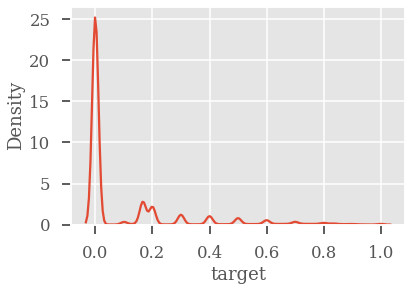

In [12]:
# Target distribution
sns.kdeplot(x='target', data=df_train);

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

**Converting target feature from continuous to catagorical using threshold of 0.5**

In [13]:
df_train['cat_target'] = df_train['target'].apply(lambda x : 'non toxic' if x<0.5 else 'toxic')
df_train.tail(2)

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,cat_target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6334009,0.621212,Anyone who is quoted as having the following e...,0.030303,0.030303,0.045455,0.621212,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 01:01:10.153692+00,13,6333833.0,399519,approved,0,0,0,0,0,0.0,0,66,toxic
6334010,0.000000,Students defined as EBD are legally just as di...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 01:01:10.822969+00,13,6333965.0,399318,approved,0,0,0,0,0,0.0,0,4,non toxic


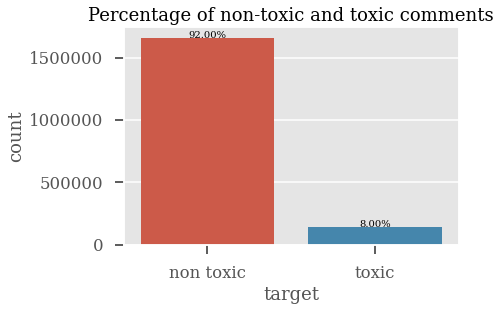

In [14]:
# Target count
fig, ax = plt.subplots(1,1)

ax.ticklabel_format(style='plain')
sns.countplot(x='cat_target', data=df_train).set_title('Percentage of non-toxic and toxic comments');
total = float(len(df_train.cat_target))

## Below code is taken from stackoverflow
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

plt.xlabel('target')
plt.show()

**Here we have an imbalanced dataset, as 92% of the comments ar4e non-toxic & only 8% are toxic.**

In [15]:
## Checking for sub-type attributes
def plot_subtype(features, data, title):
  plt.figure()
  for f in features:
    sns.kdeplot(x=f, data=data, label=f) #if we don't pass label, we can't generate legend on plot
  plt.title(title)
  plt.xlabel('')
  plt.legend()
  plt.show()

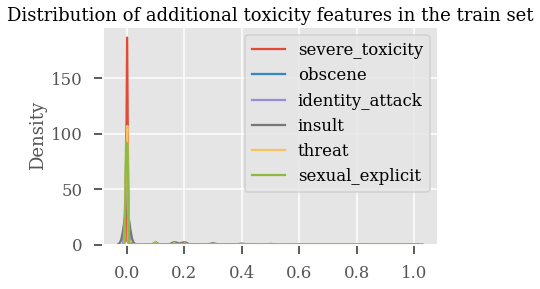

In [16]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
plot_subtype(features, df_train, 'Distribution of additional toxicity features in the train set')

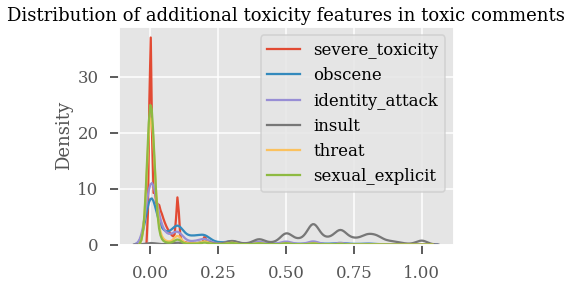

In [17]:
df_temp = df_train.loc[df_train['target']>0.5]
plot_subtype(features, df_temp, 'Distribution of additional toxicity features in toxic comments')

**Here, for all toxic comments there are more insulting type comments as compared to other types**

In [18]:
# below argmax usage logic is taken from a DS blog
# xx = [df_temp['severe_toxicity'][:1], df_temp['obscene'][:1], df_temp['identity_attack'][:1], df_temp['insult'][:1], df_temp['threat'][:1]]
# print(xx)
# np.argmax(xx)

In [19]:
# Percentage of toxicity nature in toxic comments
# below argmax usage logic is taken from a DS blog

def calc_toxicity_group(row):
  r = [row['severe_toxicity'] , row['obscene'] , row['identity_attack'] , row['insult'] , row['threat'], row['sexual_explicit']]

  amax = np.argmax(np.array(r))

  if amax == 0: return 'severe_toxicity'
  elif amax == 1: return 'obscene'
  elif amax == 2: return 'identity_attack'
  elif amax == 3: return 'insult'
  elif amax == 4: return 'threat'
  else: return 'sexual_explicit'
  

In [20]:
def plot_toxicity_nature_percentage(data,title):
  temp = data.apply(calc_toxicity_group, axis=1) # Get nature of each toxic comment

  fig, ax = plt.subplots(1,1)
  total = float(len(temp))

  # Plot the count plot.
  cntplot = sns.countplot(x=temp)
  cntplot.set_title(title)

  # Get the height and calculate percentage then display it the plot itself.
  for p in ax.patches:
      # Get height.
      height = p.get_height()
      # Plot at appropriate position.
      ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
      
  plt.show()

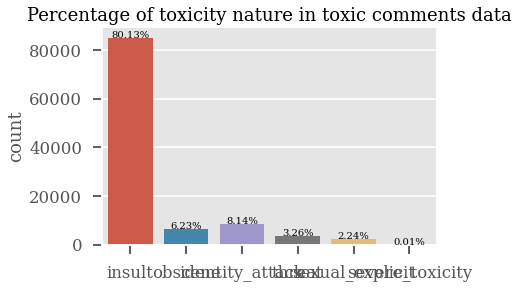

In [21]:
plot_toxicity_nature_percentage(df_temp, 'Percentage of toxicity nature in toxic comments data')

**The train dataset data contains onle 8% of the toxic comments data. <br>Out of that 8%,** 
* 81% of the toxic comments made are *insults*
* 8.14% are "identity attack* 
* 6.23% are *obscene*
* 3.26% are *threats*
* 2.24% are *sexual ecplicit* 
* and a very small amount of toxic comments are *severly toxic*.

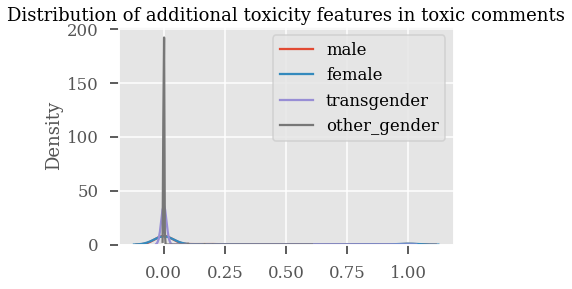

In [22]:
# Checking Distribution of additional toxicity features
features = ['male', 'female', 'transgender', 'other_gender']
plot_subtype(features, df_temp, 'Distribution of additional toxicity features in toxic comments')

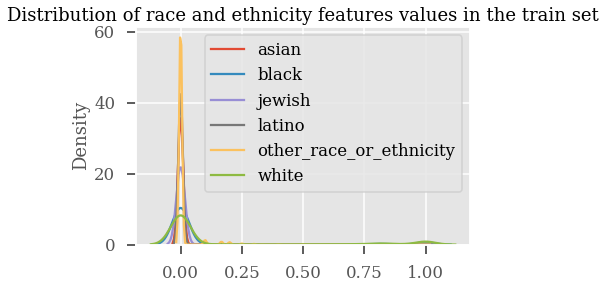

In [23]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_subtype(features, df_temp, "Distribution of race and ethnicity features values in the train set")

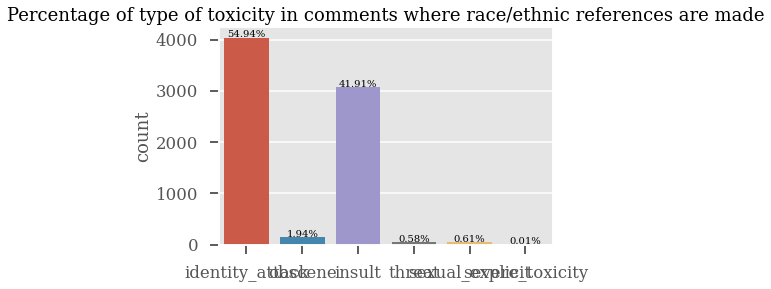

In [24]:
# Get toxic data where race/ethnic references are made.
#df_temp = toxic data whose target>0.5

cond = (df_temp['asian'] > 0.5) | (df_temp['black'] > 0.5) | (df_temp['jewish'] > 0.5) | (df_temp['latino'] > 0.5) | (df_temp['white'] > 0.5)
temp = df_temp[cond]

plot_toxicity_nature_percentage(temp,'Percentage of type of toxicity in comments where race/ethnic references are made')

**We can see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

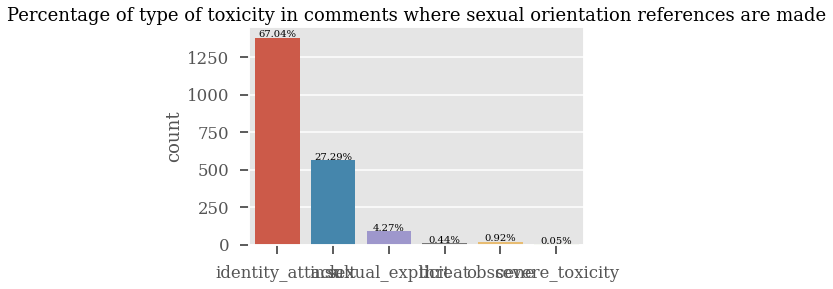

In [25]:
# Get data where sexual orientation references are made.
cond = (df_temp['bisexual'] > 0.5) | (df_temp['heterosexual'] > 0.5) | (df_temp['homosexual_gay_or_lesbian'] > 0.5) | (df_temp['other_sexual_orientation'] > 0.5) 
temp = df_temp[cond] 

plot_toxicity_nature_percentage(temp,'Percentage of type of toxicity in comments where sexual orientation references are made')

**We can see that the toxic comments involving sexual orientation words like bisexual, homosexual,gay or lesbian etc. are mainly used for identity attacks, insults & sexual_explicit.**

### Generating word-cloud

In [26]:
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1)
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=34)
        fig.subplots_adjust(top=2.6)

    plt.imshow(wordcloud)
    plt.show()

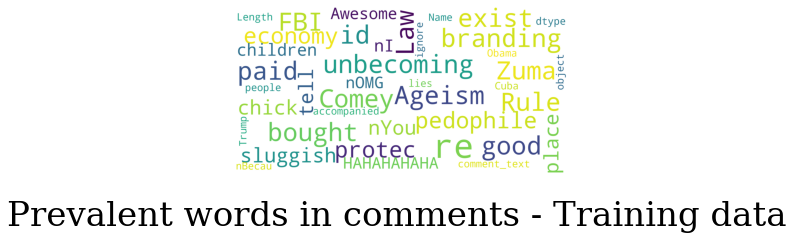

In [27]:
generate_wordcloud(df_train['comment_text'].sample(20000), title = 'Prevalent words in comments - Training data')

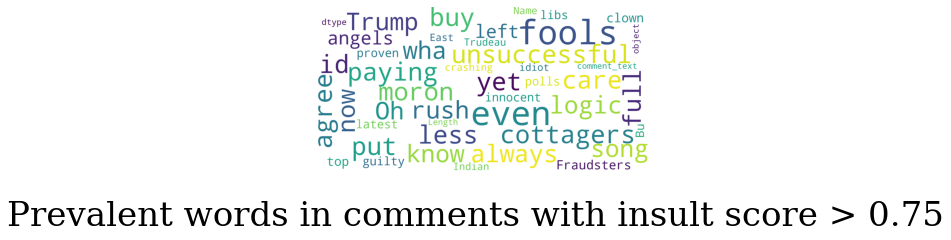

In [28]:
generate_wordcloud(df_train.loc[df_train['insult'] > 0.75]['comment_text'].sample(20000), title = 'Prevalent words in comments with insult score > 0.75')

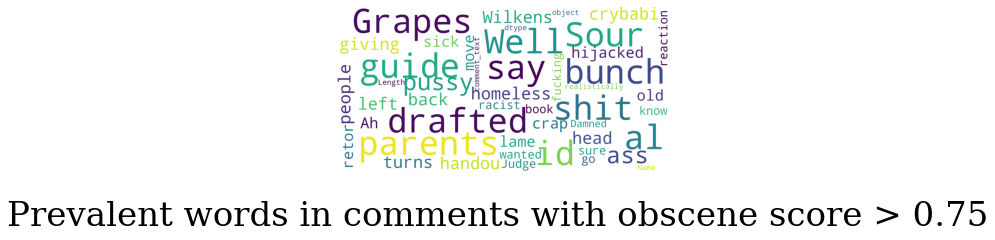

In [29]:
generate_wordcloud(df_train.loc[df_train['obscene'] > 0.75]['comment_text'], title = 'Prevalent words in comments with obscene score > 0.75')

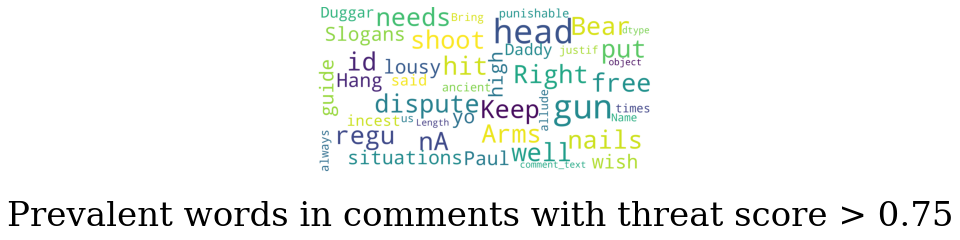

In [30]:
generate_wordcloud(df_train.loc[df_train['threat'] > 0.75]['comment_text'], title = 'Prevalent words in comments with threat score > 0.75')

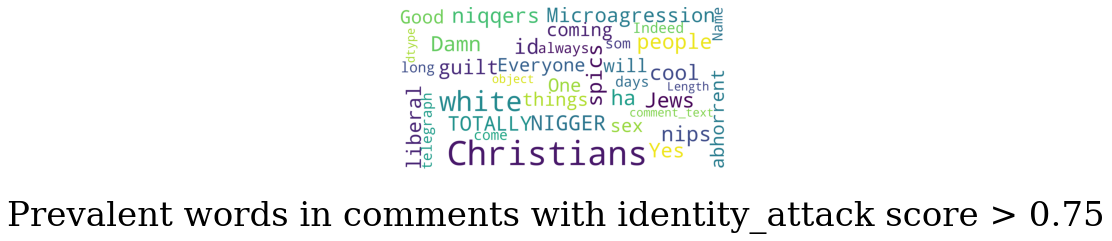

In [31]:
generate_wordcloud(df_train.loc[df_train['identity_attack'] > 0.75]['comment_text'], title = 'Prevalent words in comments with identity_attack score > 0.75')

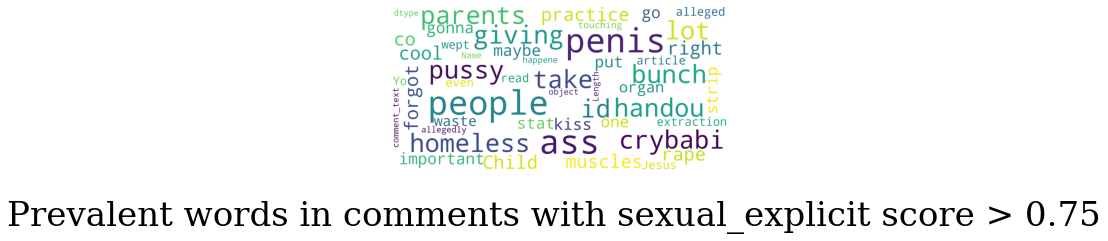

In [32]:
generate_wordcloud(df_train.loc[df_train['sexual_explicit'] > 0.75]['comment_text'], title = 'Prevalent words in comments with sexual_explicit score > 0.75')

### Text Pre-processing

In [33]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
stemmer = SnowballStemmer("english")
stopwrds = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() 
    text= re.sub('[^A-Za-z0-9]+', ' ', text)
    
    x = text.split()
    new_text = []
    
    for word in x:
        if word not in stopwrds:
            new_text.append(stemmer.stem(word))
            
    text = ' '.join(new_text)
    return text

In [ ]:
df_train['preprocessed_text'] = df_train['comment_text'].apply(preprocess_text)

In [ ]:
df_train.head(2)

In [ ]:
X = df_train[['preprocessed_text']]
y = df_train[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(X, y)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

In [ ]:
df_test['preprocessed_text'] = df_test['comment_text'].apply(preprocess_text)

In [ ]:
X_test = df_test[['preprocessed_text']]
X_test.head()

In [ ]:
# Saving the files so that we dont need to preprocess again.
!mkdir '/content/dataset/preprocessed/'
X_train.to_pickle('/content/dataset/preprocessed/X_train.pkl')
X_cv.to_pickle('/content/dataset/preprocessed/X_cv.pkl')
X_test.to_pickle('/content/dataset/preprocessed/X_test.pkl')
y_train.to_pickle('/content/dataset/preprocessed/y_train.pkl')
y_cv.to_pickle('/content/dataset/preprocessed/y_cv.pkl')

To read.... `X_train = pd.read_pickle('X_train.pkl')`

### Model Creation/Training

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

#### 1. BOW

In [ ]:
# cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
# bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
# bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
# bow_test = cnt_vec.transform(X_test['preprocessed_text'])

# print(bow_train.shape)
# print(bow_cv.shape)
# print(bow_test.shape)

A. SGDRegressor

In [ ]:
# # Performing hyperparameter tuning:

# alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# penalty = ['l1', 'l2']
# xticks = []
# tr_errors = []
# cv_errors = []
# best_model = None
# best_error = 100
# for a in alpha:
#     for p in penalty:
#         xticks.append(str(a) + ' ' + p)
#         print(str(a) + ' ' + p + " :")
        
#         model = SGDRegressor(alpha=a, penalty=p) 
#         model.fit(bow_train, y_train) # Train
        
#         preds = model.predict(bow_train) # Get predictions
#         err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
#         tr_errors.append(err)
#         print("Mean Squared Error on train set: ", err)
        
#         preds = model.predict(bow_cv) # Get predictions on CV set
#         err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
#         cv_errors.append(err)
#         print("Mean Squared Error on cv set: ", err)
        
#         if err < best_error: # Get best model trained
#             best_error = err
#             best_model = model
        
#         print("*"*50)

In [ ]:
# plt.figure(figsize=(15,5))
# plt.suptitle("Hyperparameters vs MSE")
# plt.plot(range(len(alpha) * len(penalty)), tr_errors)
# plt.plot(range(len(alpha) * len(penalty)), cv_errors)
# plt.legend(['train', 'cv'])
# plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
# plt.xlabel('Hyperparameter: alpha + penalty')
# plt.ylabel('Mean Squared Error')
# plt.show()

In [ ]:
# # Getting the best model parameters:
# best_model.get_params()

In [ ]:
# # Printing the 20 most important words which contribute to a comment being toxic.
# feat_names = cnt_vec.get_feature_names_out()
# weights = best_model.coef_
# df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
# df.sort_values("weights", ascending=False).iloc[0:10,:]

In [ ]:
# # 10 most important features/words which contribute to comment being non-toxic.
# df.sort_values("weights", ascending=True).iloc[0:10,:]

B. Decision Trees:

In [ ]:
# # Performing hyperparameter tuning:
# max_depth = [3, 5, 7]
# min_samples = [10, 100, 1000]
# xticks = []
# tr_errors = []
# cv_errors = []
# best_model = None
# best_error = 100
# for d in max_depth:
#     for samp in min_samples:
#         xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
#         print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
#         model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
#         model.fit(bow_train, y_train) # Train
        
#         preds = model.predict(bow_train) # Get predictions
#         err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
#         tr_errors.append(err)
#         print("Mean Squared Error on train set: ", err)
        
#         preds = model.predict(bow_cv) # Get predictions on CV set
#         err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
#         cv_errors.append(err)
#         print("Mean Squared Error on cv set: ", err)
        
#         if err < best_error: # Get best model trained
#             best_error = err
#             best_model = model
        
#         print("*"*50)

In [ ]:
# plt.figure(figsize=(15,5))
# plt.suptitle("Hyperparameters vs MSE")
# plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
# plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
# plt.legend(['train', 'cv'])
# plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
# plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
# plt.ylabel('Mean Squared Error')
# plt.show()

In [ ]:
# # Best models parameters:
# best_model.get_params()

In [ ]:
# # top 10 words in toxic comments
# weights = best_model.feature_importances_
# df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
# df.sort_values("weights", ascending=False).iloc[0:10,:]

In [ ]:
# # Top 10 words in non-toxic comments
# df.sort_values("weights", ascending=True).iloc[0:10,:]

#### 2. TFIDF

In [ ]:
# tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
# tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
# tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
# tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

# print(tfidf_train.shape)
# print(tfidf_cv.shape)
# print(tfidf_test.shape)

A. SGDRegressor

In [ ]:
# # Performing hyperparameter tuning:
# alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# penalty = ['l1', 'l2']
# xticks = []
# tr_errors = []
# cv_errors = []
# best_model = None
# best_error = 100
# for a in alpha:
#     for p in penalty:
#         xticks.append(str(a) + ' ' + p)
#         print(str(a) + ' ' + p + " :")
        
#         model = SGDRegressor(alpha=a, penalty=p) 
#         model.fit(tfidf_train, y_train) # Train
        
#         preds = model.predict(tfidf_train) # Get predictions
#         err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
#         tr_errors.append(err)
#         print("Mean Squared Error on train set: ", err)
        
#         preds = model.predict(tfidf_cv) # Get predictions on CV set
#         err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
#         cv_errors.append(err)
#         print("Mean Squared Error on cv set: ", err)
        
#         if err < best_error: # Get best model trained
#             best_error = err
#             best_model = model
        
#         print("*"*50)

In [ ]:
# plt.figure(figsize=(15,5))
# plt.suptitle("Hyperparameters vs MSE")
# plt.plot(range(len(alpha) * len(penalty)), tr_errors)
# plt.plot(range(len(alpha) * len(penalty)), cv_errors)
# plt.legend(['train', 'cv'])
# plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
# plt.xlabel('Hyperparameter: alpha + penalty')
# plt.ylabel('Mean Squared Error')
# plt.show()

In [ ]:
# # Printing the 10 most important words which contribute to a comment being toxic.
# feat_names = tfidf_vec.get_feature_names()
# weights = best_model.coef_
# df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
# df.sort_values("weights", ascending=False).iloc[0:10,:]

In [ ]:
# # 10 most important features/words which contribute to comment being non-toxic.
# df.sort_values("weights", ascending=True).iloc[0:10,:]

B. Decision Tree

In [ ]:
# # Performing hyperparameter tuning:
# max_depth = [3, 5, 7]
# min_samples = [10, 100, 1000]
# xticks = []
# tr_errors = []
# cv_errors = []
# best_model = None
# best_error = 100
# for d in max_depth:
#     for samp in min_samples:
#         xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
#         print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
#         model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
#         model.fit(tfidf_train, y_train) # Train
        
#         preds = model.predict(tfidf_train) # Get predictions
#         err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
#         tr_errors.append(err)
#         print("Mean Squared Error on train set: ", err)
        
#         preds = model.predict(tfidf_cv) # Get predictions on CV set
#         err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
#         cv_errors.append(err)
#         print("Mean Squared Error on cv set: ", err)
        
#         if err < best_error: # Get best model trained
#             best_error = err
#             best_model = model
        
#         print("*"*50)

In [ ]:
# plt.figure(figsize=(15,5))
# plt.suptitle("Hyperparameters vs MSE")
# plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
# plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
# plt.legend(['train', 'cv'])
# plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
# plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
# plt.ylabel('Mean Squared Error')
# plt.show()

In [ ]:
# weights = best_model.feature_importances_
# df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
# df.sort_values("weights", ascending=False).iloc[0:10,:]

In [ ]:
# df.sort_values("weights", ascending=True).iloc[0:10,:]

### LSTM:

Below code is taken from internet

In [ ]:
import keras

In [ ]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [ ]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [ ]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [ ]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

In [ ]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [ ]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(lstm_train, y_train, nb_epoch=5,batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)